In [6]:
!pip install kaggle
!pip install nibabel 
!pip install matplotlib
!pip install nilearn
!pip install scikit-learn
!pip install scikit-image
!pip install monai
!pip install einops
!pip install torch
!pip install torchvision
!pip install segmentation_models_pytorch
!pip install timm
!pip install opencv-contrib-python
!pip install ipywidgets 'pyvista[all,trame]' 
!pip install ipywidgets  

  Using cached kaggle-1.6.14-py3-none-any.whl
  Obtaining dependency information for python-slugify from https://files.pythonhosted.org/packages/a4/62/02da182e544a51a5c3ccf4b03ab79df279f9c60c5e82d5e8bec7ca26ac11/python_slugify-8.0.4-py2.py3-none-any.whl.metadata
  Using cached python_slugify-8.0.4-py2.py3-none-any.whl.metadata (8.5 kB)
  Obtaining dependency information for text-unidecode>=1.3 from https://files.pythonhosted.org/packages/a6/a5/c0b6468d3824fe3fde30dbb5e1f687b291608f9473681bbf7dabbf5a87d7/text_unidecode-1.3-py2.py3-none-any.whl.metadata
  Using cached text_unidecode-1.3-py2.py3-none-any.whl.metadata (2.4 kB)
Using cached python_slugify-8.0.4-py2.py3-none-any.whl (10 kB)
Using cached text_unidecode-1.3-py2.py3-none-any.whl (78 kB)
  Obtaining dependency information for nibabel from https://files.pythonhosted.org/packages/77/3f/ce43b8c2ccc4a7913a87c4d425aaf0080ea3abf947587e47dc2025981a17/nibabel-5.2.1-py3-none-any.whl.metadata
  Using cached nibabel-5.2.1-py3-none-any.whl.

## Imports

In [4]:
import os
import torchvision
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader, random_split
from torch.nn.functional import interpolate
import timm
import segmentation_models_pytorch as smp
from tqdm import tqdm
import nibabel as nib
import matplotlib.pyplot as plt
import numpy as np
from nilearn import plotting
import gc
from sklearn.model_selection import train_test_split
from skimage import exposure
# import cv2
from monai.transforms import (
    Compose,
    RandFlipd,
    RandRotate90d,
    RandGaussianNoised,
    ToTensord
)




## Hyperparameters

In [4]:
backbone = 'resnet18d'
DATASET_DIR = './Hepatic_dataset'
kernel_type = 'Unet'
log_dir = './logs'
model_dir = './models'
NUM_EPOCHS = 50
init_lr = 1e-3
target_size = (128, 128, 128)
batch_size = 2
seed = 42
DEBUG = False
drop_rate = 0.
drop_path_rate = 0.
loss_weights = [1, 1]
n_blocks = 4
p_mixup = 0.1
out_dim = 1
# Create a mapping of class ID to RGB value
color2id = {
    (0, 0, 0): 0,  # background pixel
    (0, 0, 255): 1,  # Blue - Stomach
    (0, 255, 0): 2,  # Green - Small bowel
    (255, 0, 0): 3,  # Red - Large bowel
}
 
# Reverse map from id to color
id2color = {v: k for k, v in color2id.items()}
# Check if CUDA is available and use it
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

Using device: cuda


## Data

In [4]:
# !kaggle datasets download -d xiaoweixumedicalai/imagecas

In [5]:
# # Replace change2 zip with zip

# directory = './CAS_dataset'

# # Iterate through the directory
# for filename in os.listdir(directory):
#     if filename.endswith('.change2zip'):
#         full_path = os.path.join(directory, filename)
#         new_filename = os.path.splitext(full_path)[0] + '.zip'
#         os.rename(full_path, new_filename)
#         print(f"Renamed {filename} to {new_filename}")


In [6]:
# import os

# directory = './CAS_dataset'
# output_folder = './CAS_dataset/Extracted_data'

# # Iterate through the directory and extract .zip files
# for filename in os.listdir(directory):
#     if filename.endswith('.zip'):
#         full_path = os.path.join(directory, filename)
#         !7z x "{full_path}" -o"{output_folder}"


## Visualizing Data

In [7]:
def num_to_rgb(num_arr, color_map=id2color):
    single_layer = np.squeeze(num_arr)
    output = np.zeros(num_arr.shape[:2] + (3,))
 
    for k in color_map.keys():
        output[single_layer == k] = color_map[k]
 
    # return a floating point array in range [0.0, 1.0]
    return np.float32(output) / 255.0

In [8]:
def image_overlay(image, segmented_image):
    alpha = 1.0  # Transparency for the original image.
    beta = 0.7  # Transparency for the segmentation map.
    gamma = 0.0  # Scalar added to each sum.
 
    segmented_image = cv2.cvtColor(segmented_image, cv2.COLOR_RGB2BGR)
 
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
 
    image = cv2.addWeighted(image, alpha, segmented_image, beta, gamma, image)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
 
    return np.clip(image, 0.0, 1.0)

In [9]:
def display_image_and_mask(*, images, masks, color_map=id2color):
    title = ["GT Image", "Color Mask", "Overlayed Mask"]
 
    for idx in range(images.shape[0]):
        image = images[idx]
        grayscale_gt_mask = masks[idx]
 
        fig = plt.figure(figsize=(15, 4))
 
        # Create RGB segmentation map from grayscale segmentation map.
        rgb_gt_mask = num_to_rgb(grayscale_gt_mask, color_map=color_map)
 
        # Create the overlayed image.
        overlayed_image = image_overlay(image, rgb_gt_mask)
 
        plt.subplot(1, 3, 1)
        plt.title(title[0])
        plt.imshow(image)
        plt.axis("off")
 
        plt.subplot(1, 3, 2)
        plt.title(title[1])
        plt.imshow(rgb_gt_mask)
        plt.axis("off")
 
        plt.imshow(rgb_gt_mask)
        plt.subplot(1, 3, 3)
        plt.title(title[2])
        plt.imshow(overlayed_image)
        plt.axis("off")
 
        plt.tight_layout()
        plt.show()
 
    return

## Preprocessing

In [10]:
def load_nii_file(filepath):
    """Load a NIfTI file and return the data as a numpy array."""
    nii = nib.load(filepath)
    return nii.get_fdata()

def enhance_contrast_nii(image):
    # Min-max normalization
    min_val = np.min(image)
    max_val = np.max(image)
    normalized_image = (image - min_val) / (max_val - min_val)
    
    # Enhance contrast
    enhanced_image = np.zeros_like(normalized_image)
    for i in range(normalized_image.shape[-1]):  # Iterate over slices
        enhanced_image[..., i] = exposure.equalize_adapthist(normalized_image[..., i])

    return torch.tensor(enhanced_image, dtype=torch.float32)

def preprocess_image(image, label, target_size, device):
    """Resize and enhance contrast for the image using PyTorch on the specified device."""
    # Enhance contrast
    image_contrasted = enhance_contrast_nii(image)
    image_tensor = torch.tensor(image_contrasted, dtype=torch.float32, device=device).unsqueeze(0).unsqueeze(0)
    image_resized = interpolate(image_tensor, size=target_size, mode='trilinear', align_corners=False)
    
    return image_resized.squeeze().cpu().numpy()

def preprocess_label(label, target_size, device):
    """Resize the label image using PyTorch on the specified device."""
    label_tensor = torch.tensor(label, dtype=torch.float32, device=device).unsqueeze(0).unsqueeze(0)
    label_resized = interpolate(label_tensor, size=target_size, mode='nearest')
    return label_resized.squeeze().cpu().numpy()



def load_and_preprocess_CAS_data(base_folder, target_size=(128, 128, 128), device='cpu'):
    images_preprocessed = []
    labels_preprocessed = []
    processed_count = 0

    # Use tqdm to wrap the outer loop for progress bar
    for subdir, _, files in os.walk(base_folder):
        for filename in files:
            if filename.endswith('.img.nii.gz'):
                image_path = os.path.join(subdir, filename)
                label_filename = filename.replace('.img.nii.gz', '.label.nii.gz')
                label_path = os.path.join(subdir, label_filename)
                
                if os.path.exists(label_path):
                    # Load the image and label
                    try:
                        image = load_nii_file(image_path)
                        label = load_nii_file(label_path)
                    except Exception as e:
                        print(f"Error loading {filename}: {e}")
                        continue
                    
                    # Preprocess the image and label
                    try:
                        image_preprocessed = preprocess_image(image, label, target_size, device)
                        label_preprocessed = preprocess_label(label, target_size, device)
                        # visualize_image_and_mask(image_preprocessed[..., target_size[0] // 2], label_preprocessed[..., target_size[0] // 2])  # Visualize a slice
                    except Exception as e:
                        print(f"Error preprocessing {filename}: {e}")
                        continue

                    images_preprocessed.append(image_preprocessed)
                    labels_preprocessed.append(label_preprocessed)
                    
                    processed_count += 1
                    if processed_count % 50 == 0:  # Debug: print status every 50 files
                        print(f"Processed {processed_count} files")
    
    return np.array(images_preprocessed), np.array(labels_preprocessed)




In [11]:
base_folder = './CAS_dataset/Extracted_data'
images, labels = load_and_preprocess_CAS_data(base_folder)

/tmp/ipykernel_17871/2582625296.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image_tensor = torch.tensor(image_contrasted, dtype=torch.float32, device=device).unsqueeze(0).unsqueeze(0)


Processed 50 files
Processed 100 files
Processed 150 files
Processed 200 files
Processed 250 files
Processed 300 files
Processed 350 files
Processed 400 files
Processed 450 files
Processed 500 files
Processed 550 files
Processed 600 files
Processed 650 files
Processed 700 files
Processed 750 files
Processed 800 files
Processed 850 files
Processed 900 files
Processed 950 files
Processed 1000 files


In [12]:
def visualize_image_and_mask(image, mask, slice_index=None):
    """Visualize the middle slice or a specific slice of a 3D image and mask."""
    if slice_index is None:
        slice_index = image.shape[0] // 2

    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    axs[0].imshow(image[slice_index], cmap='gray')
    axs[0].set_title('Image')

    axs[1].imshow(mask[slice_index], cmap='viridis')
    axs[1].set_title('Mask')

    plt.show()

In [13]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_image_and_mask(image, mask, slice_index=None):
    """Visualize the middle slice or a specific slice of a 3D image and mask."""
    if slice_index is None:
        slice_index = image.shape[0] // 2

    fig, axs = plt.subplots(1, 3, figsize=(18, 6))

    # Plotting the image
    axs[0].imshow(image[slice_index], cmap='gray')
    axs[0].set_title('Image')

    # Plotting the mask
    axs[1].imshow(mask[slice_index], cmap='viridis')
    axs[1].set_title('Mask')

    # Plotting the mask overlaid on the image
    overlay = np.ma.masked_where(mask[slice_index] == 0, mask[slice_index])
    axs[2].imshow(image[slice_index], cmap='gray')
    axs[2].imshow(overlay, cmap='viridis', alpha=0.5)  # Adjust alpha for overlay transparency
    axs[2].set_title('Overlay (Image + Mask)')

    plt.tight_layout()
    plt.show()


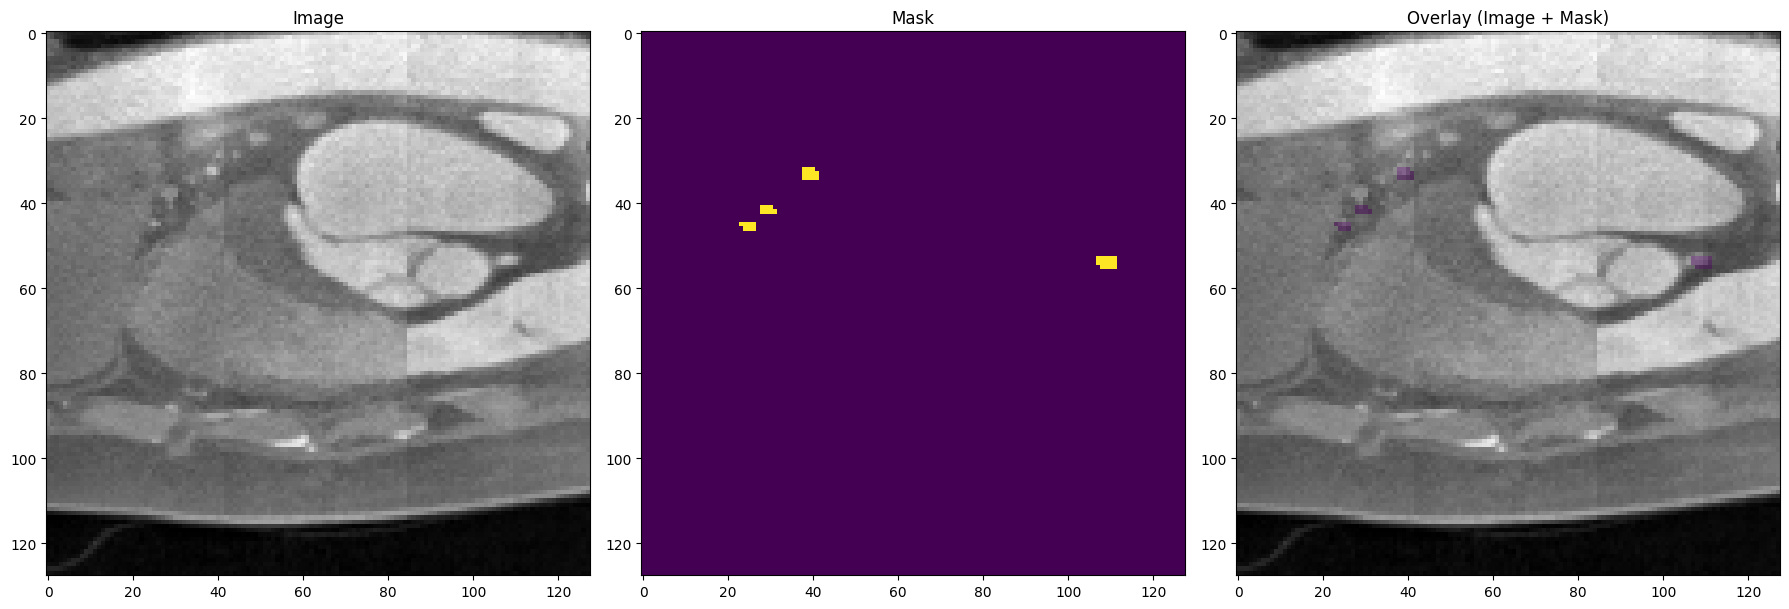

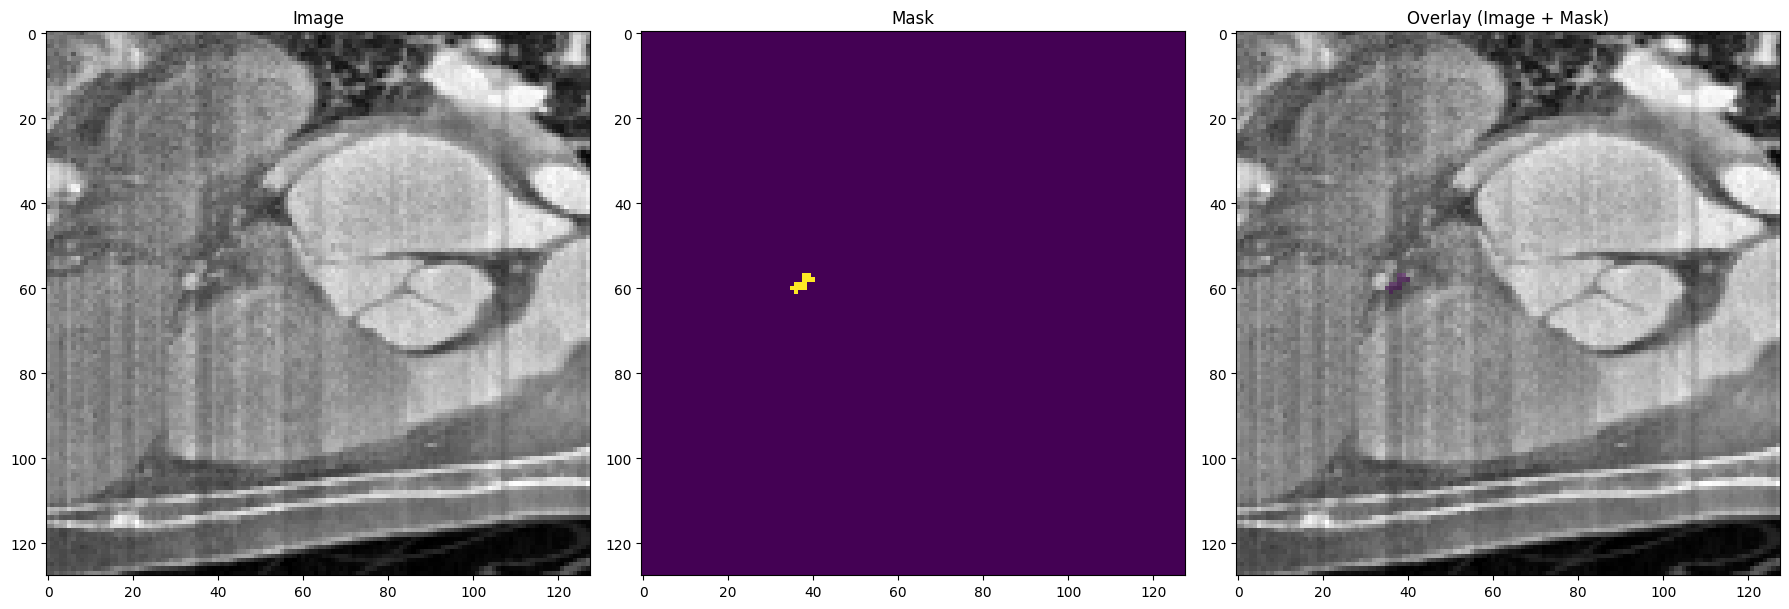

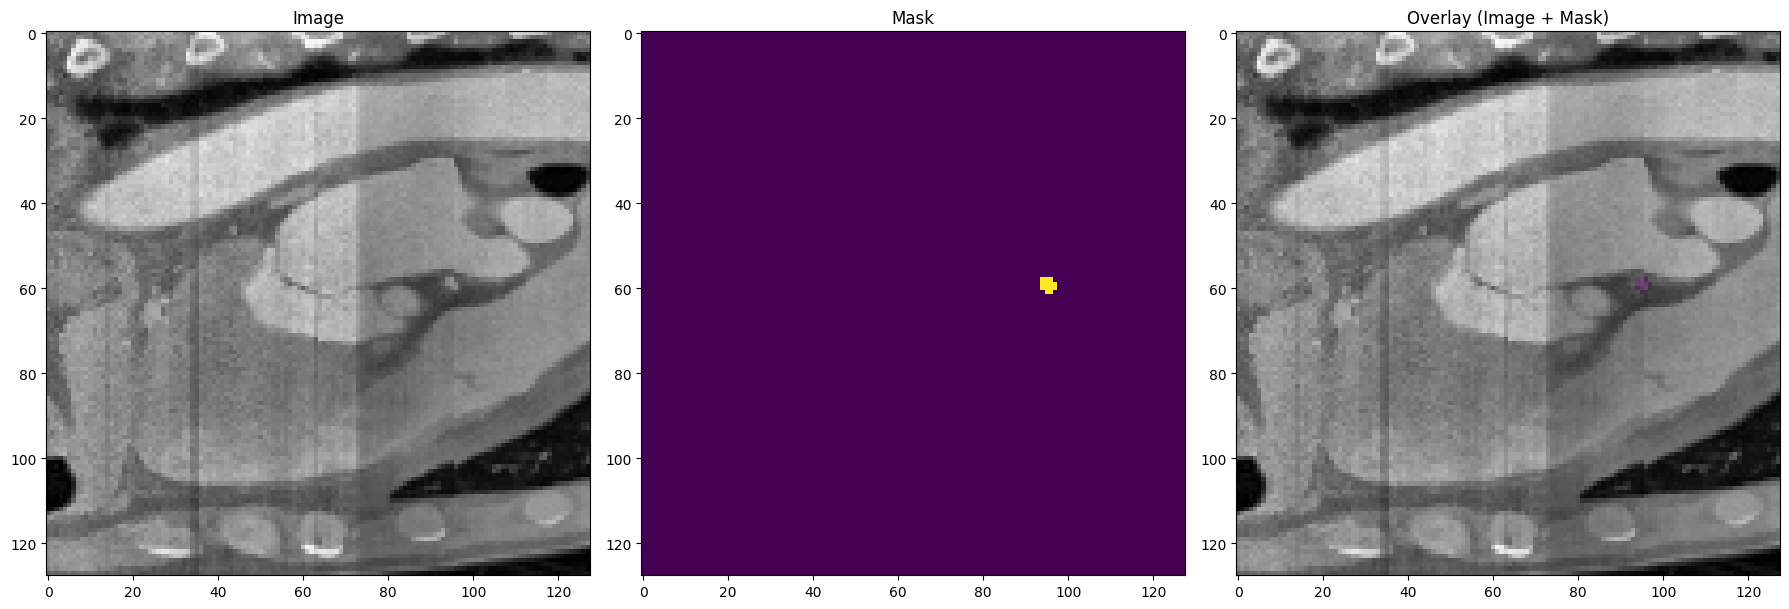

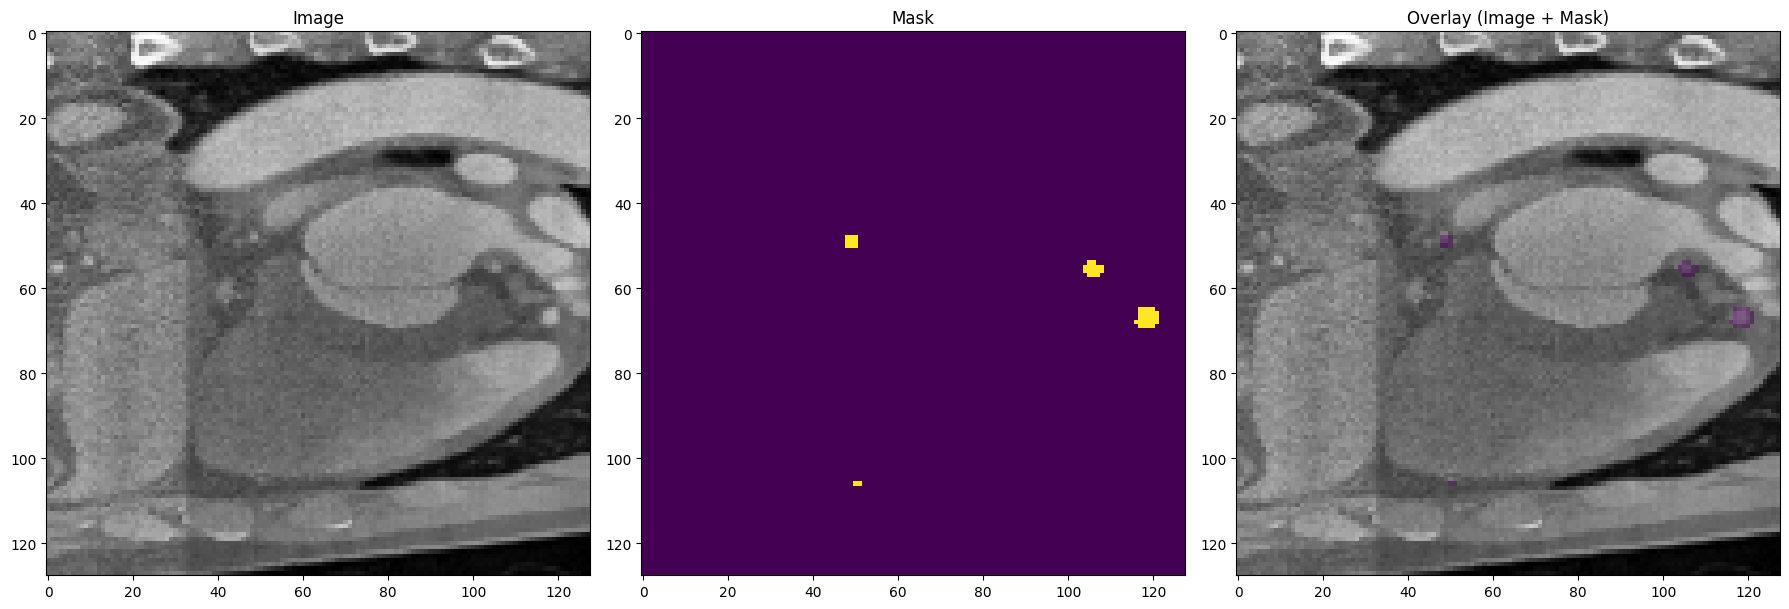

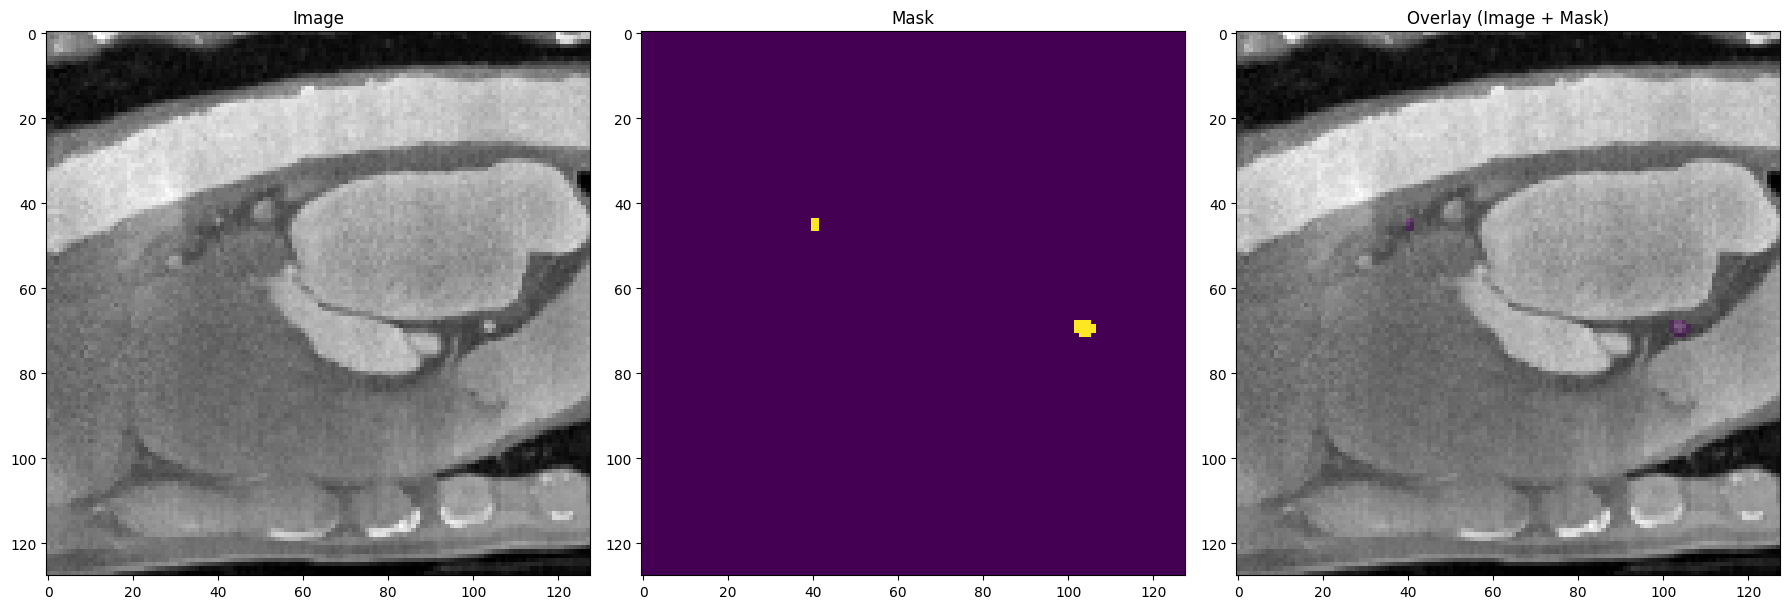

In [14]:
# Loop to visualize random images and masks
for i in np.random.randint(0, 8, size=5):  # Visualize 5 random images
    visualize_image_and_mask(images[i], labels[i])


## Custom Dataset

In [15]:
seed_value = np.random.randint(0, 2**32 - 1)

# Define your transformation pipeline
transform = Compose().set_random_state(seed=seed_value)


tranform = transform([
    RandFlipd(keys=['image', 'label'], prob=0.5, spatial_axis=[0]),
    RandRotate90d(keys=['image', 'label'], prob=0.9, spatial_axes=[0, 1]),
    RandGaussianNoised(keys=['image'], prob=0.5, mean=1.9, std=0.1),
    ToTensord(keys=['image', 'label'])
])

In [16]:
class Dataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        
        # Add channel dimension
        image = np.expand_dims(image, axis=0)
        label = np.expand_dims(label, axis=0)
        
        sample = {'image': image, 'label': label}
        
        if self.transform:
            sample = self.transform(sample)
        
        return sample['image'], sample['label']

## Dataloader

In [17]:
# Assuming img and msk are your preprocessed images and labels arrays
dataset = Dataset(images, labels)
# Aug_dataset = Dataset(images, labels, transform = transform)


In [18]:
# for idx in np.random.randint(0, 9, size=5):
#     image, label = Aug_dataset[idx]
#     visualize_image_and_mask(image.squeeze(), label.squeeze())

In [19]:
# combined_dataset = dataset + Aug_dataset

# Split the dataset into training and validation sets
train_size = int(0.7 * len(dataset))
val_size = int(0.2* len(dataset)) 
test_size = len(dataset) - train_size - val_size  # Adjust to ensure total size matches
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Create DataLoaders

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

print(f"Number of training samples: {len(train_loader.dataset)}")
print(f"Number of validation samples: {len(val_loader.dataset)}")
print(f"Number of test samples: {len(test_loader.dataset)}")

# for batch in train_loader:
#     inputs, targets = batch  # Assuming each batch contains inputs and targets
#     # Print the shape of input and target tensors
#     print("Input shape:", inputs.shape)
#     print("Target shape:", targets.shape)  # Only if targets are available


Number of training samples: 700
Number of validation samples: 200
Number of test samples: 100


In [20]:
# for batch_images, batch_masks in val_loader:
 
#     batch_images = batch_images.numpy()
#     batch_masks  = batch_masks.numpy()
 
#     print("batch_images shape:", batch_images.shape)
#     print("batch_masks shape: ", batch_masks.shape)
     
#     display_image_and_mask(images=batch_images, masks=batch_masks)
 
#     break

## Model

In [5]:
class TimmSegModel(nn.Module):
    def __init__(self, backbone, segtype='unet', pretrained=False):
        super(TimmSegModel, self).__init__()

        self.encoder = timm.create_model(
            backbone,
            in_chans=1,
            features_only=True,
            drop_rate=drop_rate,
            drop_path_rate=drop_path_rate,
            pretrained=pretrained
        )
        g = self.encoder(torch.rand(1, 1, 64, 64))
        encoder_channels = [1] + [_.shape[1] for _ in g]
        decoder_channels = [256, 128, 64, 32, 16]
        if segtype == 'unet':
            self.decoder = smp.decoders.unet.model.UnetDecoder(
                encoder_channels=encoder_channels[:n_blocks+1],
                decoder_channels=decoder_channels[:n_blocks],
                n_blocks=n_blocks,
            )

        self.segmentation_head = nn.Conv2d(decoder_channels[n_blocks-1], out_dim, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

    def forward(self,x):
        global_features = [0] + self.encoder(x)[:n_blocks]
        seg_features = self.decoder(*global_features)
        seg_features = self.segmentation_head(seg_features)
        return seg_features

In [2]:
""" Conv3d w/ Same Padding
modified from:
https://github.com/rwightman/pytorch-image-models/blob/a2727c1bf78ba0d7b5727f5f95e37fb7f8866b1f/timm/models/layers/conv2d_same.py
https://github.com/rwightman/pytorch-image-models/blob/a2727c1bf78ba0d7b5727f5f95e37fb7f8866b1f/timm/models/layers/padding.py
"""
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from typing import Tuple, Optional, List


# Calculate symmetric padding for a convolution
def get_padding(kernel_size: int, stride: int = 1, dilation: int = 1, **_) -> int:
    padding = ((stride - 1) + dilation * (kernel_size - 1)) // 2
    return padding


# Calculate asymmetric TensorFlow-like 'SAME' padding for a convolution
def get_same_padding(x: int, k: int, s: int, d: int):
    return max((math.ceil(x / s) - 1) * s + (k - 1) * d + 1 - x, 0)


# Can SAME padding for given args be done statically?
def is_static_pad(kernel_size: int, stride: int = 1, dilation: int = 1, **_):
    return stride == 1 and (dilation * (kernel_size - 1)) % 2 == 0


# Dynamically pad input x with 'SAME' padding for conv with specified args
def pad_same(x, k: List[int], s: List[int], d: List[int] = (1, 1, 1), value: float = 0):
    ih, iw, iz = x.size()[-3:]
    pad_h = get_same_padding(ih, k[0], s[0], d[0])
    pad_w = get_same_padding(iw, k[1], s[1], d[1])
    pad_z = get_same_padding(iz, k[2], s[2], d[2])
    if pad_h > 0 or pad_w > 0 or pad_z > 0:
        x = F.pad(x, [pad_w // 2, pad_w - pad_w // 2, pad_h // 2, pad_h - pad_h // 2, pad_z // 2, pad_z - pad_z // 2], value=value)
    return x


def get_padding_value(padding, kernel_size, **kwargs) -> Tuple[Tuple, bool]:
    dynamic = False
    if isinstance(padding, str):
        # for any string padding, the padding will be calculated for you, one of three ways
        padding = padding.lower()
        if padding == 'same':
            # TF compatible 'SAME' padding, has a performance and GPU memory allocation impact
            if is_static_pad(kernel_size, **kwargs):
                # static case, no extra overhead
                padding = get_padding(kernel_size, **kwargs)
            else:
                # dynamic 'SAME' padding, has runtime/GPU memory overhead
                padding = 0
                dynamic = True
        elif padding == 'valid':
            # 'VALID' padding, same as padding=0
            padding = 0
        else:
            # Default to PyTorch style 'same'-ish symmetric padding
            padding = get_padding(kernel_size, **kwargs)
    return padding, dynamic


def conv3d_same(
        x, weight: torch.Tensor, bias: Optional[torch.Tensor] = None, stride: Tuple[int, int, int] = (1, 1, 1),
        padding: Tuple[int, int, int] = (0, 0, 0), dilation: Tuple[int, int, int] = (1, 1, 1), groups: int = 1):
    x = pad_same(x, weight.shape[-3:], stride, dilation)
    return F.conv3d(x, weight, bias, stride, (0, 0, 0), dilation, groups)


class Conv3dSame(nn.Conv3d):
    """ Tensorflow like 'SAME' convolution wrapper for 3d convolutions
    """

    def __init__(self, in_channels, out_channels, kernel_size, stride=1,
                 padding=0, dilation=1, groups=1, bias=True):
        super(Conv3dSame, self).__init__(
            in_channels, out_channels, kernel_size, stride, 0, dilation, groups, bias)

    def forward(self, x):
        return conv3d_same(x, self.weight, self.bias, self.stride, self.padding, self.dilation, self.groups)


def create_conv3d_pad(in_chs, out_chs, kernel_size, **kwargs):
    padding = kwargs.pop('padding', '')
    kwargs.setdefault('bias', False)
    padding, is_dynamic = get_padding_value(padding, kernel_size, **kwargs)
    if is_dynamic:
        return Conv3dSame(in_chs, out_chs, kernel_size, **kwargs)
    else:
        return nn.Conv3d(in_chs, out_chs, kernel_size, padding=padding, **kwargs)

In [3]:
from timm.layers.conv2d_same import Conv2dSame, conv2d_same
# from conv3d_same import Conv3dSame


def convert_3d(module):

    module_output = module
    if isinstance(module, torch.nn.BatchNorm2d):
        module_output = torch.nn.BatchNorm3d(
            module.num_features,
            module.eps,
            module.momentum,
            module.affine,
            module.track_running_stats,
        )
        if module.affine:
            with torch.no_grad():
                module_output.weight = module.weight
                module_output.bias = module.bias
        module_output.running_mean = module.running_mean
        module_output.running_var = module.running_var
        module_output.num_batches_tracked = module.num_batches_tracked
        if hasattr(module, "qconfig"):
            module_output.qconfig = module.qconfig
            
    elif isinstance(module, Conv2dSame):
        module_output = Conv3dSame(
            in_channels=module.in_channels,
            out_channels=module.out_channels,
            kernel_size=module.kernel_size[0],
            stride=module.stride[0],
            padding=module.padding[0],
            dilation=module.dilation[0],
            groups=module.groups,
            bias=module.bias is not None,
        )
        module_output.weight = torch.nn.Parameter(module.weight.unsqueeze(-1).repeat(1,1,1,1,module.kernel_size[0]))

    elif isinstance(module, torch.nn.Conv2d):
        module_output = torch.nn.Conv3d(
            in_channels=module.in_channels,
            out_channels=module.out_channels,
            kernel_size=module.kernel_size[0],
            stride=module.stride[0],
            padding=module.padding[0],
            dilation=module.dilation[0],
            groups=module.groups,
            bias=module.bias is not None,
            padding_mode=module.padding_mode
        )
        module_output.weight = torch.nn.Parameter(module.weight.unsqueeze(-1).repeat(1,1,1,1,module.kernel_size[0]))

    elif isinstance(module, torch.nn.MaxPool2d):
        module_output = torch.nn.MaxPool3d(
            kernel_size=module.kernel_size,
            stride=module.stride,
            padding=module.padding,
            dilation=module.dilation,
            ceil_mode=module.ceil_mode,
        )
    elif isinstance(module, torch.nn.AvgPool2d):
        module_output = torch.nn.AvgPool3d(
            kernel_size=module.kernel_size,
            stride=module.stride,
            padding=module.padding,
            ceil_mode=module.ceil_mode,
        )

    for name, child in module.named_children():
        module_output.add_module(
            name, convert_3d(child)
        )
    del module

    return module_output

In [7]:
UnetModel = TimmSegModel(backbone)
UnetModel = convert_3d(UnetModel)

NameError: name 'backbone' is not defined

## Metrics & Losses

In [25]:
loss_weights = [1, 1]

def dice_loss(input, target):
    input = torch.sigmoid(input)
    smooth = 1.0
    iflat = input.view(-1)
    tflat = target.view(-1)
    intersection = (iflat * tflat).sum()
    return 1 - ((2.0 * intersection + smooth) / (iflat.sum() + tflat.sum() + smooth))


def bce_dice(input, target, loss_weights=loss_weights):
    loss1 = loss_weights[0] * nn.BCEWithLogitsLoss()(input, target)
    loss2 = loss_weights[1] * dice_loss(input, target)
    return (loss1 + loss2) / sum(loss_weights)



In [26]:
def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor, threshold=0.5):
    # You can comment out this line if you are passing tensors of equal shape
    # But if you are passing output from UNet or something it will most probably
    # be with the BATCH x 1 x H x W shape
    SMOOTH = 1e-6
    # outputs = outputs.squeeze(1)  # BATCH x 1 x H x W => BATCH x H x W
    # labels = labels.squeeze(1)

    bin_out = torch.where(outputs > threshold, 1, 0).type(torch.int16)
    labels = labels.type(torch.int16)

    intersection = (bin_out & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    union = (bin_out | labels).float().sum((1, 2))         # Will be zero if both are 0

    iou = (intersection + SMOOTH) / (union + SMOOTH)  # We smooth our division to avoid 0/0

    thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10  # This is equal to comparing with thresolds

    return thresholded.mean()  # Or thresholded.mean() if you are interested in average across the batch


In [27]:
def compute_accuracy_and_loss(model, data_loader, device):
    """
    Compute the accuracy and loss of the model on the given data loader.

    Args:
        model (torch.nn.Module): The neural network model.
        data_loader (DataLoader): DataLoader providing the data for evaluation.
        device (torch.device): Device (CPU or GPU) where the computation will be performed.
        lossFunc (function): Loss function to use for computation.
        metricFunc (function): Metric function to use for computing accuracy.

    Returns:
        float: Average accuracy of the model on the dataset (%).
        float: Average loss of the model on the dataset.
    """
    model.eval()  # Set the model to evaluation mode.
    correct_pred, num_examples = 0, 0
    total_loss, total_metric = 0.0, 0.0
    lossFunc =  dice_loss
    metricFunc = iou_pytorch
    
    with torch.no_grad():
        for features, targets in tqdm(data_loader):
            # Move features and targets to the specified device.
            features = features.to(device)
            targets = targets.to(device)

            # Forward pass: Compute logits using the model.
            logits = model(features)

            # Compute loss and add it to the total.
            loss = lossFunc(logits, targets)
            total_loss += loss.item() * features.size(0)

            # Compute the metric and update the total.
            metric = metricFunc(logits.detach(), targets)
            # total_metric += metric * features.size(0)

            # Update the total number of examples.
            num_examples += features.size(0)

            torch.cuda.empty_cache()
            gc.collect()

    # Calculate average accuracy and loss over all examples.
    average_accuracy = metric * 100 #(total_metric / num_examples)*100
    average_loss = total_loss / num_examples

    return average_accuracy, average_loss



In [28]:
optimizer = optim.AdamW(UnetModel.parameters(), lr=init_lr)

## Training and Validation

In [29]:
def train(model, train_loader, valid_loader, optimizer, NUM_EPOCHS, DEVICE):
    """
    Train a neural network model.

    Args:
        model (torch.nn.Module): The neural network model to be trained.
        train_loader (DataLoader): DataLoader providing training data.
        valid_loader (DataLoader): DataLoader providing validation data.
        optimizer (torch.optim.Optimizer): Optimizer for updating model parameters.
        NUM_EPOCHS (int): Number of training epochs.
        DEVICE (torch.device): Device (CPU or GPU) for computation.

    Returns:
        list: List of training accuracies for each epoch.
        list: List of validation accuracies for each epoch.
        list: List of training losses for each epoch.
        list: List of validation losses for each epoch.
    """
    model.to(DEVICE)
    start_time = time.time()
    train_acc_lst, valid_acc_lst = [], []
    train_loss_lst, valid_loss_lst = [], []
    lossFunc = dice_loss
    log_file = os.path.join(log_dir, f'{kernel_type}.txt')
    model_file = os.path.join(model_dir, f'{kernel_type}_best_CAS.pth')
    best_valid_acc = 0.
    # Loop over each epoch.
    
    for epoch in range(NUM_EPOCHS):
        model.train()  # Set the model to training mode.

        # Loop over each batch in the training data.
        
        for batch_idx, (images, targets) in enumerate(tqdm(train_loader)):
            # Placing images and ground-truths to the hardware device
            images = images.to(DEVICE)
            targets = targets.to(DEVICE)

            # print("Input shape:", images.shape)
            # print("Target shape:", targets.shape) 

            # Feedforward- and backward propagation
            logits = model.forward(images)
            # print(logits.shape)
            cost = lossFunc(logits, targets)
            optimizer.zero_grad()  # Reset gradients to zero.

            cost.backward()  # Perform backpropagation.

            # Updating model's parameters using optimiser, e.g. w = w - lr*deriv
            optimizer.step()  # Update model parameters.

            # logging
            if not batch_idx % (len(train_loader)/batch_size):
                # Print training progress.
                print(f'Epoch: {epoch+1:03d}/{NUM_EPOCHS:03d} | '
                      f'Batch {batch_idx:03d}/{len(train_loader):03d} |'
                      f' Cost: {cost:.4f}')

        # Set the model to evaluation mode for computing validation metrics.
        model.eval()
        with torch.set_grad_enabled(False):
            # Compute accuracy and loss on training and validation datasets.
            train_acc, train_loss = compute_accuracy_and_loss(model, train_loader, DEVICE)
            valid_acc, valid_loss = compute_accuracy_and_loss(model, valid_loader, DEVICE)

            # Append metrics to respective lists.
            train_acc_lst.append(train_acc)
            valid_acc_lst.append(valid_acc)
            train_loss_lst.append(train_loss)
            valid_loss_lst.append(valid_loss)

            # Print training and validation accuracies.
            print(f'Epoch: {epoch+1:03d}/{NUM_EPOCHS:03d} Train Acc.: {train_acc:.4f}%'
                  f' | Validation Acc.: {valid_acc:.4f}%')

         # Save the best model based on validation accuracy
        if valid_acc > best_valid_acc:
            best_valid_acc = valid_acc
            print(f'Validation accuracy improved ({best_valid_acc:.2f}%). Saving model ...')
            torch.save(model.state_dict(), model_file)

        # Save Last
        if not DEBUG:
            torch.save(
                {
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'score_best': best_valid_acc,
                },
                model_file.replace('_best', '_last')
            )

        # Calculate elapsed time and print it.
        elapsed = (time.time() - start_time) / 60
        print(f'Time elapsed: {elapsed:.2f} min')

    # Print total training time.
    elapsed = (time.time() - start_time) / 60
    print(f'Total Training Time: {elapsed:.2f} min')

    del model
    torch.cuda.empty_cache()
    gc.collect()

    # Return lists of training and validation accuracies and losses.
    return train_acc_lst, valid_acc_lst, train_loss_lst, valid_loss_lst

In [30]:
train_acc_lst, valid_acc_lst, train_loss_lst, valid_loss_lst= train(UnetModel, train_loader, val_loader, optimizer, NUM_EPOCHS, device)

  0%|          | 1/350 [00:04<26:27,  4.55s/it]

Epoch: 001/050 | Batch 000/350 | Cost: 0.9972


 50%|█████     | 176/350 [05:13<06:37,  2.29s/it]

Epoch: 001/050 | Batch 175/350 | Cost: 0.4668


100%|██████████| 100/100 [01:07<00:00,  1.48it/s]


Epoch: 001/050 Train Acc.: 94.6521% | Validation Acc.: 93.0344%
Validation accuracy improved (93.03%). Saving model ...
Time elapsed: 15.38 min


  0%|          | 1/350 [00:02<13:13,  2.27s/it]

Epoch: 002/050 | Batch 000/350 | Cost: 0.3180


 50%|█████     | 176/350 [05:11<06:38,  2.29s/it]

Epoch: 002/050 | Batch 175/350 | Cost: 0.3291


100%|██████████| 100/100 [01:07<00:00,  1.47it/s]


Epoch: 002/050 Train Acc.: 95.6577% | Validation Acc.: 93.4146%
Validation accuracy improved (93.41%). Saving model ...
Time elapsed: 30.75 min


  0%|          | 1/350 [00:02<13:08,  2.26s/it]

Epoch: 003/050 | Batch 000/350 | Cost: 0.3071


 50%|█████     | 176/350 [05:11<06:38,  2.29s/it]

Epoch: 003/050 | Batch 175/350 | Cost: 0.3989


100%|██████████| 100/100 [01:09<00:00,  1.44it/s]


Epoch: 003/050 Train Acc.: 94.8334% | Validation Acc.: 93.6197%
Validation accuracy improved (93.62%). Saving model ...
Time elapsed: 46.13 min


  0%|          | 1/350 [00:02<13:05,  2.25s/it]

Epoch: 004/050 | Batch 000/350 | Cost: 0.2999


 50%|█████     | 176/350 [05:11<06:38,  2.29s/it]

Epoch: 004/050 | Batch 175/350 | Cost: 0.3473


100%|██████████| 100/100 [01:07<00:00,  1.48it/s]


Epoch: 004/050 Train Acc.: 95.3207% | Validation Acc.: 93.2971%
Time elapsed: 61.47 min


  0%|          | 1/350 [00:02<13:21,  2.30s/it]

Epoch: 005/050 | Batch 000/350 | Cost: 0.2973


 50%|█████     | 176/350 [05:11<06:38,  2.29s/it]

Epoch: 005/050 | Batch 175/350 | Cost: 0.2742


100%|██████████| 100/100 [01:07<00:00,  1.47it/s]


Epoch: 005/050 Train Acc.: 95.5246% | Validation Acc.: 94.1187%
Validation accuracy improved (94.12%). Saving model ...
Time elapsed: 76.90 min


  0%|          | 1/350 [00:02<13:07,  2.26s/it]

Epoch: 006/050 | Batch 000/350 | Cost: 0.3068


 50%|█████     | 176/350 [05:11<06:38,  2.29s/it]

Epoch: 006/050 | Batch 175/350 | Cost: 0.2834


100%|██████████| 100/100 [01:10<00:00,  1.41it/s]


Epoch: 006/050 Train Acc.: 96.0446% | Validation Acc.: 94.2203%
Validation accuracy improved (94.22%). Saving model ...
Time elapsed: 92.31 min


  0%|          | 1/350 [00:02<13:33,  2.33s/it]

Epoch: 007/050 | Batch 000/350 | Cost: 0.3441


 50%|█████     | 176/350 [05:11<06:38,  2.29s/it]

Epoch: 007/050 | Batch 175/350 | Cost: 0.2739


100%|██████████| 100/100 [01:07<00:00,  1.49it/s]


Epoch: 007/050 Train Acc.: 94.6823% | Validation Acc.: 93.4683%
Time elapsed: 107.60 min


  0%|          | 1/350 [00:02<13:19,  2.29s/it]

Epoch: 008/050 | Batch 000/350 | Cost: 0.2443


 50%|█████     | 176/350 [05:10<06:37,  2.29s/it]

Epoch: 008/050 | Batch 175/350 | Cost: 0.2978


100%|██████████| 100/100 [01:07<00:00,  1.47it/s]


Epoch: 008/050 Train Acc.: 97.3294% | Validation Acc.: 94.4272%
Validation accuracy improved (94.43%). Saving model ...
Time elapsed: 122.95 min


  0%|          | 1/350 [00:02<13:03,  2.24s/it]

Epoch: 009/050 | Batch 000/350 | Cost: 0.1979


 50%|█████     | 176/350 [05:11<06:38,  2.29s/it]

Epoch: 009/050 | Batch 175/350 | Cost: 0.2023


100%|██████████| 100/100 [01:07<00:00,  1.48it/s]


Epoch: 009/050 Train Acc.: 94.8941% | Validation Acc.: 94.3710%
Time elapsed: 138.32 min


  0%|          | 1/350 [00:02<13:05,  2.25s/it]

Epoch: 010/050 | Batch 000/350 | Cost: 0.2146


 50%|█████     | 176/350 [05:11<06:38,  2.29s/it]

Epoch: 010/050 | Batch 175/350 | Cost: 0.2600


100%|██████████| 100/100 [01:07<00:00,  1.47it/s]


Epoch: 010/050 Train Acc.: 96.3080% | Validation Acc.: 94.0375%
Time elapsed: 153.69 min


  0%|          | 1/350 [00:02<13:11,  2.27s/it]

Epoch: 011/050 | Batch 000/350 | Cost: 0.2184


 50%|█████     | 176/350 [05:11<06:38,  2.29s/it]

Epoch: 011/050 | Batch 175/350 | Cost: 0.2877


100%|██████████| 100/100 [01:07<00:00,  1.47it/s]


Epoch: 011/050 Train Acc.: 94.6747% | Validation Acc.: 94.5099%
Validation accuracy improved (94.51%). Saving model ...
Time elapsed: 169.07 min


  0%|          | 1/350 [00:02<13:34,  2.34s/it]

Epoch: 012/050 | Batch 000/350 | Cost: 0.2332


 50%|█████     | 176/350 [05:11<06:38,  2.29s/it]

Epoch: 012/050 | Batch 175/350 | Cost: 0.2370


100%|██████████| 100/100 [01:07<00:00,  1.48it/s]


Epoch: 012/050 Train Acc.: 97.3538% | Validation Acc.: 94.6368%
Validation accuracy improved (94.64%). Saving model ...
Time elapsed: 184.39 min


  0%|          | 1/350 [00:02<13:13,  2.28s/it]

Epoch: 013/050 | Batch 000/350 | Cost: 0.1893


 50%|█████     | 176/350 [05:11<06:38,  2.29s/it]

Epoch: 013/050 | Batch 175/350 | Cost: 0.1820


100%|██████████| 100/100 [01:08<00:00,  1.47it/s]


Epoch: 013/050 Train Acc.: 97.3795% | Validation Acc.: 94.5694%
Time elapsed: 199.73 min


  0%|          | 1/350 [00:02<13:10,  2.27s/it]

Epoch: 014/050 | Batch 000/350 | Cost: 0.1948


 50%|█████     | 176/350 [05:10<06:37,  2.29s/it]

Epoch: 014/050 | Batch 175/350 | Cost: 0.2515


100%|██████████| 100/100 [01:07<00:00,  1.48it/s]


Epoch: 014/050 Train Acc.: 96.6989% | Validation Acc.: 94.7684%
Validation accuracy improved (94.77%). Saving model ...
Time elapsed: 215.07 min


  0%|          | 1/350 [00:02<13:09,  2.26s/it]

Epoch: 015/050 | Batch 000/350 | Cost: 0.2229


 50%|█████     | 176/350 [05:11<06:38,  2.29s/it]

Epoch: 015/050 | Batch 175/350 | Cost: 0.1883


100%|██████████| 100/100 [01:07<00:00,  1.49it/s]


Epoch: 015/050 Train Acc.: 95.0204% | Validation Acc.: 94.7711%
Validation accuracy improved (94.77%). Saving model ...
Time elapsed: 230.42 min


  0%|          | 1/350 [00:02<13:05,  2.25s/it]

Epoch: 016/050 | Batch 000/350 | Cost: 0.1944


 50%|█████     | 176/350 [05:10<06:38,  2.29s/it]

Epoch: 016/050 | Batch 175/350 | Cost: 0.2164


100%|██████████| 100/100 [01:07<00:00,  1.48it/s]


Epoch: 016/050 Train Acc.: 97.2153% | Validation Acc.: 94.4644%
Time elapsed: 245.73 min


  0%|          | 1/350 [00:02<13:16,  2.28s/it]

Epoch: 017/050 | Batch 000/350 | Cost: 0.1343


 50%|█████     | 176/350 [05:11<06:38,  2.29s/it]

Epoch: 017/050 | Batch 175/350 | Cost: 0.1914


100%|██████████| 100/100 [01:07<00:00,  1.48it/s]


Epoch: 017/050 Train Acc.: 96.6309% | Validation Acc.: 94.8059%
Validation accuracy improved (94.81%). Saving model ...
Time elapsed: 261.06 min


  0%|          | 1/350 [00:02<13:52,  2.39s/it]

Epoch: 018/050 | Batch 000/350 | Cost: 0.1646


 50%|█████     | 176/350 [05:11<06:37,  2.29s/it]

Epoch: 018/050 | Batch 175/350 | Cost: 0.2164


100%|██████████| 100/100 [01:07<00:00,  1.47it/s]


Epoch: 018/050 Train Acc.: 97.6923% | Validation Acc.: 94.8962%
Validation accuracy improved (94.90%). Saving model ...
Time elapsed: 276.42 min


  0%|          | 1/350 [00:02<13:28,  2.32s/it]

Epoch: 019/050 | Batch 000/350 | Cost: 0.1537


 50%|█████     | 176/350 [05:11<06:38,  2.29s/it]

Epoch: 019/050 | Batch 175/350 | Cost: 0.1772


100%|██████████| 100/100 [01:08<00:00,  1.45it/s]


Epoch: 019/050 Train Acc.: 96.4346% | Validation Acc.: 94.8630%
Time elapsed: 291.75 min


  0%|          | 1/350 [00:02<13:17,  2.29s/it]

Epoch: 020/050 | Batch 000/350 | Cost: 0.1619


 50%|█████     | 176/350 [05:11<06:37,  2.29s/it]

Epoch: 020/050 | Batch 175/350 | Cost: 0.1755


100%|██████████| 100/100 [01:07<00:00,  1.49it/s]


Epoch: 020/050 Train Acc.: 96.5414% | Validation Acc.: 94.7818%
Time elapsed: 307.08 min


  0%|          | 1/350 [00:02<13:16,  2.28s/it]

Epoch: 021/050 | Batch 000/350 | Cost: 0.1765


 50%|█████     | 176/350 [05:11<06:37,  2.29s/it]

Epoch: 021/050 | Batch 175/350 | Cost: 0.1485


100%|██████████| 100/100 [01:07<00:00,  1.49it/s]


Epoch: 021/050 Train Acc.: 96.3828% | Validation Acc.: 94.8740%
Time elapsed: 322.44 min


  0%|          | 1/350 [00:02<13:37,  2.34s/it]

Epoch: 022/050 | Batch 000/350 | Cost: 0.1820


 50%|█████     | 176/350 [05:10<06:37,  2.29s/it]

Epoch: 022/050 | Batch 175/350 | Cost: 0.1557


100%|██████████| 100/100 [01:07<00:00,  1.48it/s]


Epoch: 022/050 Train Acc.: 96.3864% | Validation Acc.: 94.9301%
Validation accuracy improved (94.93%). Saving model ...
Time elapsed: 337.75 min


  0%|          | 1/350 [00:02<13:00,  2.24s/it]

Epoch: 023/050 | Batch 000/350 | Cost: 0.1422


 50%|█████     | 176/350 [05:10<06:37,  2.29s/it]

Epoch: 023/050 | Batch 175/350 | Cost: 0.1473


100%|██████████| 100/100 [01:07<00:00,  1.49it/s]


Epoch: 023/050 Train Acc.: 96.8591% | Validation Acc.: 94.7745%
Time elapsed: 353.04 min


  0%|          | 1/350 [00:02<13:31,  2.33s/it]

Epoch: 024/050 | Batch 000/350 | Cost: 0.1489


 50%|█████     | 176/350 [05:10<06:38,  2.29s/it]

Epoch: 024/050 | Batch 175/350 | Cost: 0.1619


100%|██████████| 100/100 [01:09<00:00,  1.45it/s]


Epoch: 024/050 Train Acc.: 96.1496% | Validation Acc.: 94.6613%
Time elapsed: 368.38 min


  0%|          | 1/350 [00:02<13:10,  2.27s/it]

Epoch: 025/050 | Batch 000/350 | Cost: 0.1447


 50%|█████     | 176/350 [05:10<06:37,  2.29s/it]

Epoch: 025/050 | Batch 175/350 | Cost: 0.1344


100%|██████████| 100/100 [01:06<00:00,  1.49it/s]


Epoch: 025/050 Train Acc.: 96.7419% | Validation Acc.: 94.6320%
Time elapsed: 383.71 min


  0%|          | 1/350 [00:02<13:01,  2.24s/it]

Epoch: 026/050 | Batch 000/350 | Cost: 0.1346


 50%|█████     | 176/350 [05:10<06:37,  2.29s/it]

Epoch: 026/050 | Batch 175/350 | Cost: 0.1670


100%|██████████| 100/100 [01:07<00:00,  1.49it/s]


Epoch: 026/050 Train Acc.: 96.8262% | Validation Acc.: 94.7946%
Time elapsed: 399.00 min


  0%|          | 1/350 [00:02<12:59,  2.23s/it]

Epoch: 027/050 | Batch 000/350 | Cost: 0.1638


 50%|█████     | 176/350 [05:10<06:37,  2.28s/it]

Epoch: 027/050 | Batch 175/350 | Cost: 0.1870


100%|██████████| 100/100 [01:06<00:00,  1.50it/s]


Epoch: 027/050 Train Acc.: 97.3077% | Validation Acc.: 94.9133%
Time elapsed: 414.29 min


  0%|          | 1/350 [00:02<13:17,  2.28s/it]

Epoch: 028/050 | Batch 000/350 | Cost: 0.1524


 50%|█████     | 176/350 [05:10<06:37,  2.28s/it]

Epoch: 028/050 | Batch 175/350 | Cost: 0.1281


100%|██████████| 100/100 [01:06<00:00,  1.49it/s]


Epoch: 028/050 Train Acc.: 97.2745% | Validation Acc.: 94.8438%
Time elapsed: 429.60 min


  0%|          | 1/350 [00:02<13:05,  2.25s/it]

Epoch: 029/050 | Batch 000/350 | Cost: 0.1595


 50%|█████     | 176/350 [05:10<06:37,  2.28s/it]

Epoch: 029/050 | Batch 175/350 | Cost: 0.1550


100%|██████████| 100/100 [01:08<00:00,  1.46it/s]


Epoch: 029/050 Train Acc.: 95.9830% | Validation Acc.: 94.8419%
Time elapsed: 444.95 min


  0%|          | 1/350 [00:02<13:20,  2.29s/it]

Epoch: 030/050 | Batch 000/350 | Cost: 0.1516


 50%|█████     | 176/350 [05:10<06:37,  2.28s/it]

Epoch: 030/050 | Batch 175/350 | Cost: 0.1331


100%|██████████| 100/100 [01:07<00:00,  1.49it/s]


Epoch: 030/050 Train Acc.: 98.0774% | Validation Acc.: 94.8697%
Time elapsed: 460.24 min


  0%|          | 1/350 [00:02<14:12,  2.44s/it]

Epoch: 031/050 | Batch 000/350 | Cost: 0.1405


 50%|█████     | 176/350 [05:10<06:37,  2.29s/it]

Epoch: 031/050 | Batch 175/350 | Cost: 0.1331


100%|██████████| 100/100 [01:07<00:00,  1.49it/s]


Epoch: 031/050 Train Acc.: 96.5704% | Validation Acc.: 94.8538%
Time elapsed: 475.59 min


  0%|          | 1/350 [00:02<13:05,  2.25s/it]

Epoch: 032/050 | Batch 000/350 | Cost: 0.1323


 50%|█████     | 176/350 [05:10<06:37,  2.28s/it]

Epoch: 032/050 | Batch 175/350 | Cost: 0.1652


100%|██████████| 100/100 [01:07<00:00,  1.49it/s]


Epoch: 032/050 Train Acc.: 96.2515% | Validation Acc.: 94.9005%
Time elapsed: 490.87 min


  0%|          | 1/350 [00:02<13:45,  2.37s/it]

Epoch: 033/050 | Batch 000/350 | Cost: 0.1289


 50%|█████     | 176/350 [05:10<06:37,  2.28s/it]

Epoch: 033/050 | Batch 175/350 | Cost: 0.1336


100%|██████████| 100/100 [01:07<00:00,  1.49it/s]


Epoch: 033/050 Train Acc.: 96.8997% | Validation Acc.: 94.8953%
Time elapsed: 506.14 min


  0%|          | 1/350 [00:02<13:30,  2.32s/it]

Epoch: 034/050 | Batch 000/350 | Cost: 0.1663


 50%|█████     | 176/350 [05:10<06:36,  2.28s/it]

Epoch: 034/050 | Batch 175/350 | Cost: 0.1367


100%|██████████| 100/100 [01:07<00:00,  1.49it/s]


Epoch: 034/050 Train Acc.: 97.6599% | Validation Acc.: 94.7699%
Time elapsed: 521.42 min


  0%|          | 1/350 [00:02<13:47,  2.37s/it]

Epoch: 035/050 | Batch 000/350 | Cost: 0.1097


 50%|█████     | 176/350 [05:10<06:37,  2.29s/it]

Epoch: 035/050 | Batch 175/350 | Cost: 0.1475


100%|██████████| 100/100 [01:11<00:00,  1.40it/s]


Epoch: 035/050 Train Acc.: 96.9510% | Validation Acc.: 94.8413%
Time elapsed: 536.92 min


  0%|          | 1/350 [00:02<13:21,  2.30s/it]

Epoch: 036/050 | Batch 000/350 | Cost: 0.2165


 50%|█████     | 176/350 [05:10<06:37,  2.28s/it]

Epoch: 036/050 | Batch 175/350 | Cost: 0.1380


100%|██████████| 100/100 [01:06<00:00,  1.50it/s]


Epoch: 036/050 Train Acc.: 97.4393% | Validation Acc.: 94.8428%
Time elapsed: 552.23 min


  0%|          | 1/350 [00:02<13:13,  2.27s/it]

Epoch: 037/050 | Batch 000/350 | Cost: 0.1486


 50%|█████     | 176/350 [05:10<06:36,  2.28s/it]

Epoch: 037/050 | Batch 175/350 | Cost: 0.1043


100%|██████████| 100/100 [01:09<00:00,  1.44it/s]


Epoch: 037/050 Train Acc.: 97.3346% | Validation Acc.: 94.8392%
Time elapsed: 567.53 min


  0%|          | 1/350 [00:02<13:06,  2.25s/it]

Epoch: 038/050 | Batch 000/350 | Cost: 0.1379


 50%|█████     | 176/350 [05:10<06:37,  2.28s/it]

Epoch: 038/050 | Batch 175/350 | Cost: 0.1434


100%|██████████| 100/100 [01:07<00:00,  1.49it/s]


Epoch: 038/050 Train Acc.: 96.7053% | Validation Acc.: 94.6100%
Time elapsed: 582.80 min


  0%|          | 1/350 [00:02<13:12,  2.27s/it]

Epoch: 039/050 | Batch 000/350 | Cost: 0.1280


 50%|█████     | 176/350 [05:10<06:36,  2.28s/it]

Epoch: 039/050 | Batch 175/350 | Cost: 0.1116


100%|██████████| 100/100 [01:07<00:00,  1.49it/s]


Epoch: 039/050 Train Acc.: 97.9636% | Validation Acc.: 94.9283%
Time elapsed: 598.08 min


  0%|          | 1/350 [00:02<13:09,  2.26s/it]

Epoch: 040/050 | Batch 000/350 | Cost: 0.1478


 50%|█████     | 176/350 [05:10<06:36,  2.28s/it]

Epoch: 040/050 | Batch 175/350 | Cost: 0.1260


100%|██████████| 100/100 [01:07<00:00,  1.48it/s]


Epoch: 040/050 Train Acc.: 97.1582% | Validation Acc.: 94.7321%
Time elapsed: 613.36 min


  0%|          | 1/350 [00:02<13:14,  2.28s/it]

Epoch: 041/050 | Batch 000/350 | Cost: 0.1244


 50%|█████     | 176/350 [05:10<06:36,  2.28s/it]

Epoch: 041/050 | Batch 175/350 | Cost: 0.1467


100%|██████████| 100/100 [01:06<00:00,  1.50it/s]


Epoch: 041/050 Train Acc.: 97.5781% | Validation Acc.: 94.8480%
Time elapsed: 628.60 min


  0%|          | 1/350 [00:02<13:04,  2.25s/it]

Epoch: 042/050 | Batch 000/350 | Cost: 0.1302


 50%|█████     | 176/350 [05:09<06:36,  2.28s/it]

Epoch: 042/050 | Batch 175/350 | Cost: 0.1176


100%|██████████| 100/100 [01:06<00:00,  1.50it/s]


Epoch: 042/050 Train Acc.: 96.3272% | Validation Acc.: 94.7876%
Time elapsed: 643.84 min


  0%|          | 1/350 [00:02<13:59,  2.41s/it]

Epoch: 043/050 | Batch 000/350 | Cost: 0.1101


 50%|█████     | 176/350 [05:10<06:36,  2.28s/it]

Epoch: 043/050 | Batch 175/350 | Cost: 0.1389


100%|██████████| 100/100 [01:07<00:00,  1.48it/s]


Epoch: 043/050 Train Acc.: 96.8222% | Validation Acc.: 94.8114%
Time elapsed: 659.11 min


  0%|          | 1/350 [00:02<13:48,  2.38s/it]

Epoch: 044/050 | Batch 000/350 | Cost: 0.1393


 50%|█████     | 176/350 [05:10<06:37,  2.28s/it]

Epoch: 044/050 | Batch 175/350 | Cost: 0.1303


100%|██████████| 100/100 [01:08<00:00,  1.45it/s]


Epoch: 044/050 Train Acc.: 97.3224% | Validation Acc.: 94.8666%
Time elapsed: 674.47 min


  0%|          | 1/350 [00:02<13:53,  2.39s/it]

Epoch: 045/050 | Batch 000/350 | Cost: 0.1060


 50%|█████     | 176/350 [05:10<06:36,  2.28s/it]

Epoch: 045/050 | Batch 175/350 | Cost: 0.1298


100%|██████████| 100/100 [01:07<00:00,  1.48it/s]


Epoch: 045/050 Train Acc.: 97.8168% | Validation Acc.: 94.9722%
Validation accuracy improved (94.97%). Saving model ...
Time elapsed: 689.75 min


  0%|          | 1/350 [00:02<13:07,  2.26s/it]

Epoch: 046/050 | Batch 000/350 | Cost: 0.0897


 50%|█████     | 176/350 [05:09<06:36,  2.28s/it]

Epoch: 046/050 | Batch 175/350 | Cost: 0.1287


100%|██████████| 100/100 [01:07<00:00,  1.48it/s]


Epoch: 046/050 Train Acc.: 98.0121% | Validation Acc.: 94.8340%
Time elapsed: 705.03 min


  0%|          | 1/350 [00:02<13:06,  2.25s/it]

Epoch: 047/050 | Batch 000/350 | Cost: 0.1314


 50%|█████     | 176/350 [05:10<06:37,  2.28s/it]

Epoch: 047/050 | Batch 175/350 | Cost: 0.1418


100%|██████████| 100/100 [01:09<00:00,  1.44it/s]


Epoch: 047/050 Train Acc.: 97.5537% | Validation Acc.: 94.9475%
Time elapsed: 720.53 min


  0%|          | 1/350 [00:02<13:06,  2.25s/it]

Epoch: 048/050 | Batch 000/350 | Cost: 0.1155


 50%|█████     | 176/350 [05:10<06:36,  2.28s/it]

Epoch: 048/050 | Batch 175/350 | Cost: 0.1013


100%|██████████| 100/100 [01:07<00:00,  1.48it/s]


Epoch: 048/050 Train Acc.: 97.0770% | Validation Acc.: 94.9286%
Time elapsed: 735.81 min


  0%|          | 1/350 [00:02<13:03,  2.25s/it]

Epoch: 049/050 | Batch 000/350 | Cost: 0.1426


 50%|█████     | 176/350 [05:10<06:36,  2.28s/it]

Epoch: 049/050 | Batch 175/350 | Cost: 0.0972


100%|██████████| 100/100 [01:06<00:00,  1.50it/s]


Epoch: 049/050 Train Acc.: 98.3295% | Validation Acc.: 94.9588%
Time elapsed: 751.07 min


  0%|          | 1/350 [00:02<13:17,  2.29s/it]

Epoch: 050/050 | Batch 000/350 | Cost: 0.1328


 50%|█████     | 176/350 [05:10<06:36,  2.28s/it]

Epoch: 050/050 | Batch 175/350 | Cost: 0.1197


100%|██████████| 100/100 [01:07<00:00,  1.49it/s]


Epoch: 050/050 Train Acc.: 97.6053% | Validation Acc.: 94.8200%
Time elapsed: 766.37 min
Total Training Time: 766.37 min


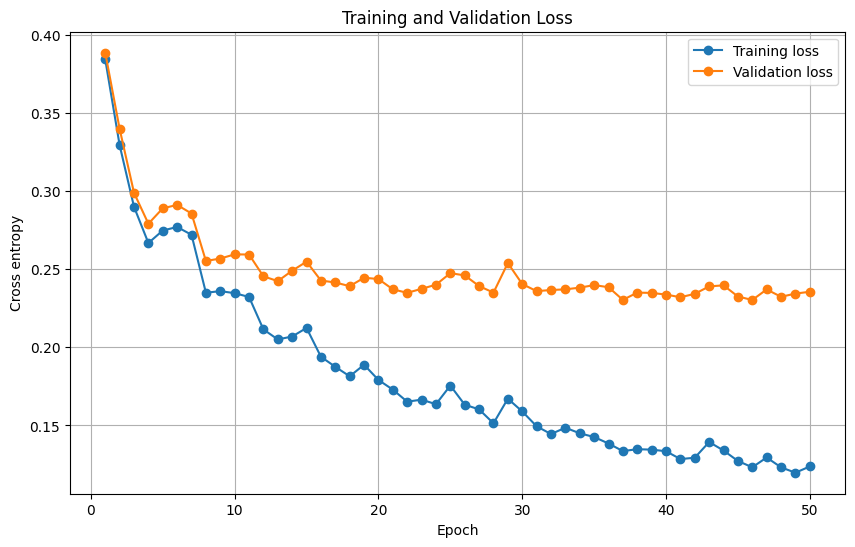

In [31]:
# Plot training and validation loss
train_loss_np = [tensor for tensor in train_loss_lst]
valid_loss_np = [tensor for tensor in valid_loss_lst]

plt.figure(figsize=(10, 6))  # Set figure size for better visibility
plt.plot(range(1, NUM_EPOCHS+1), train_loss_np, label='Training loss', marker='o')  # Plot training loss
plt.plot(range(1, NUM_EPOCHS+1), valid_loss_np, label='Validation loss', marker='o')  # Plot validation loss
plt.legend(loc='upper right')  # Add legend to upper right corner
plt.title('Training and Validation Loss')  # Set title for the plot
plt.xlabel('Epoch')  # Set label for x-axis
plt.ylabel('Cross entropy')  # Set label for y-axis
plt.grid(True)  # Add grid lines for better visualization
plt.show()  # Display the plot

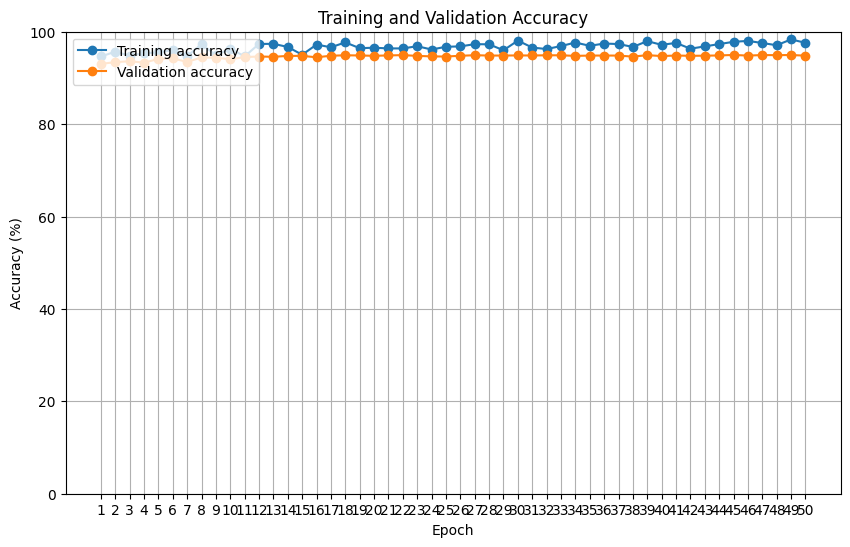

In [32]:
# Move tensors to CPU
train_acc_lst_cpu = [acc.cpu().numpy() for acc in train_acc_lst]
valid_acc_lst_cpu = [acc.cpu().numpy() for acc in valid_acc_lst]

# Plot training and validation accuracy
plt.figure(figsize=(10, 6))  # Set figure size for better visibility
plt.plot(range(1, NUM_EPOCHS+1), train_acc_lst_cpu, label='Training accuracy', marker='o')  # Plot training accuracy
plt.plot(range(1, NUM_EPOCHS+1), valid_acc_lst_cpu, label='Validation accuracy', marker='o')  # Plot validation accuracy
plt.legend(loc='upper left')  # Add legend to upper left corner
plt.title('Training and Validation Accuracy')  # Set title of the plot
plt.xlabel('Epoch')  # Set label for x-axis
plt.ylabel('Accuracy (%)')  # Set label for y-axis
plt.grid(True)  # Add grid lines for better visualization
plt.ylim(0, 100)  # Set y-axis limit from 0 to 100
plt.xticks(range(1, NUM_EPOCHS+1))  # Set x-axis ticks for each epoch
plt.show()  # Display the plot

## Testing

In [6]:
import torch

# Define the path to the saved model file
model_path = './models/Unet_best_CAS.pth'

# Load the model's state dictionary
state_dict = torch.load(model_path)

# Load the state dictionary into the model
UnetModel.load_state_dict(state_dict)
UnetModel.to(device)

NameError: name 'UnetModel' is not defined

In [34]:
test_acc, test_loss = compute_accuracy_and_loss(UnetModel, test_loader, device)
print(f'Test accuracy: {test_acc:.4f}%')

100%|██████████| 50/50 [00:34<00:00,  1.46it/s]

Test accuracy: 96.7663%


In [35]:
torch.cuda.empty_cache()
gc.collect()

0

## Visualize Segmentations

In [36]:
def visualize_segmentation(model, data_loader, num_samples=5, device='cuda'):
    # Visualize segmentation on unseen samples
    fig, axs = plt.subplots(num_samples, 3, figsize=(15, 5 * num_samples))

    # Check if there is only one sample
    if num_samples == 1:
        axs = [axs]  # Convert to a list to handle single sample case uniformly

    for ax, col in zip(axs[0], ['MRI', 'Ground Truth', 'Predicted Mask']):
        ax.set_title(col)

    index = 0
    for batch in data_loader:
        img = batch[0].to(device)
        msk = batch[1].to(device)
        model.eval()
        output = model(img)
        
        torch.cuda.empty_cache()
        gc.collect()

        for j in range(batch[0].size()[0]):  # iterate over batch size
            img_cpu = img[j].detach().cpu().numpy()  # Convert to numpy array after moving to CPU
            msk_cpu = torch.squeeze(msk[j]).detach().cpu().numpy()
            output_cpu = torch.squeeze(output[j]).detach().cpu().numpy()

            # Select a 2D slice from the 3D volume
            slice_index = img_cpu.shape[1] // 2  # Select the middle slice along the z-axis

            axs[index][0].imshow(img_cpu[0, slice_index], cmap='bone', interpolation='none')
            axs[index][1].imshow(msk_cpu[slice_index], cmap='viridis', interpolation='none', alpha=0.5)
            axs[index][2].imshow(output_cpu[slice_index], cmap='viridis', interpolation='none', alpha=0.5)

            index += 1
            if index >= num_samples:
                break

        if index >= num_samples:
            break

    plt.tight_layout()
    plt.show()

# Example usage
# visualize_segmentation(UnetModel, test_loader, 2, device)


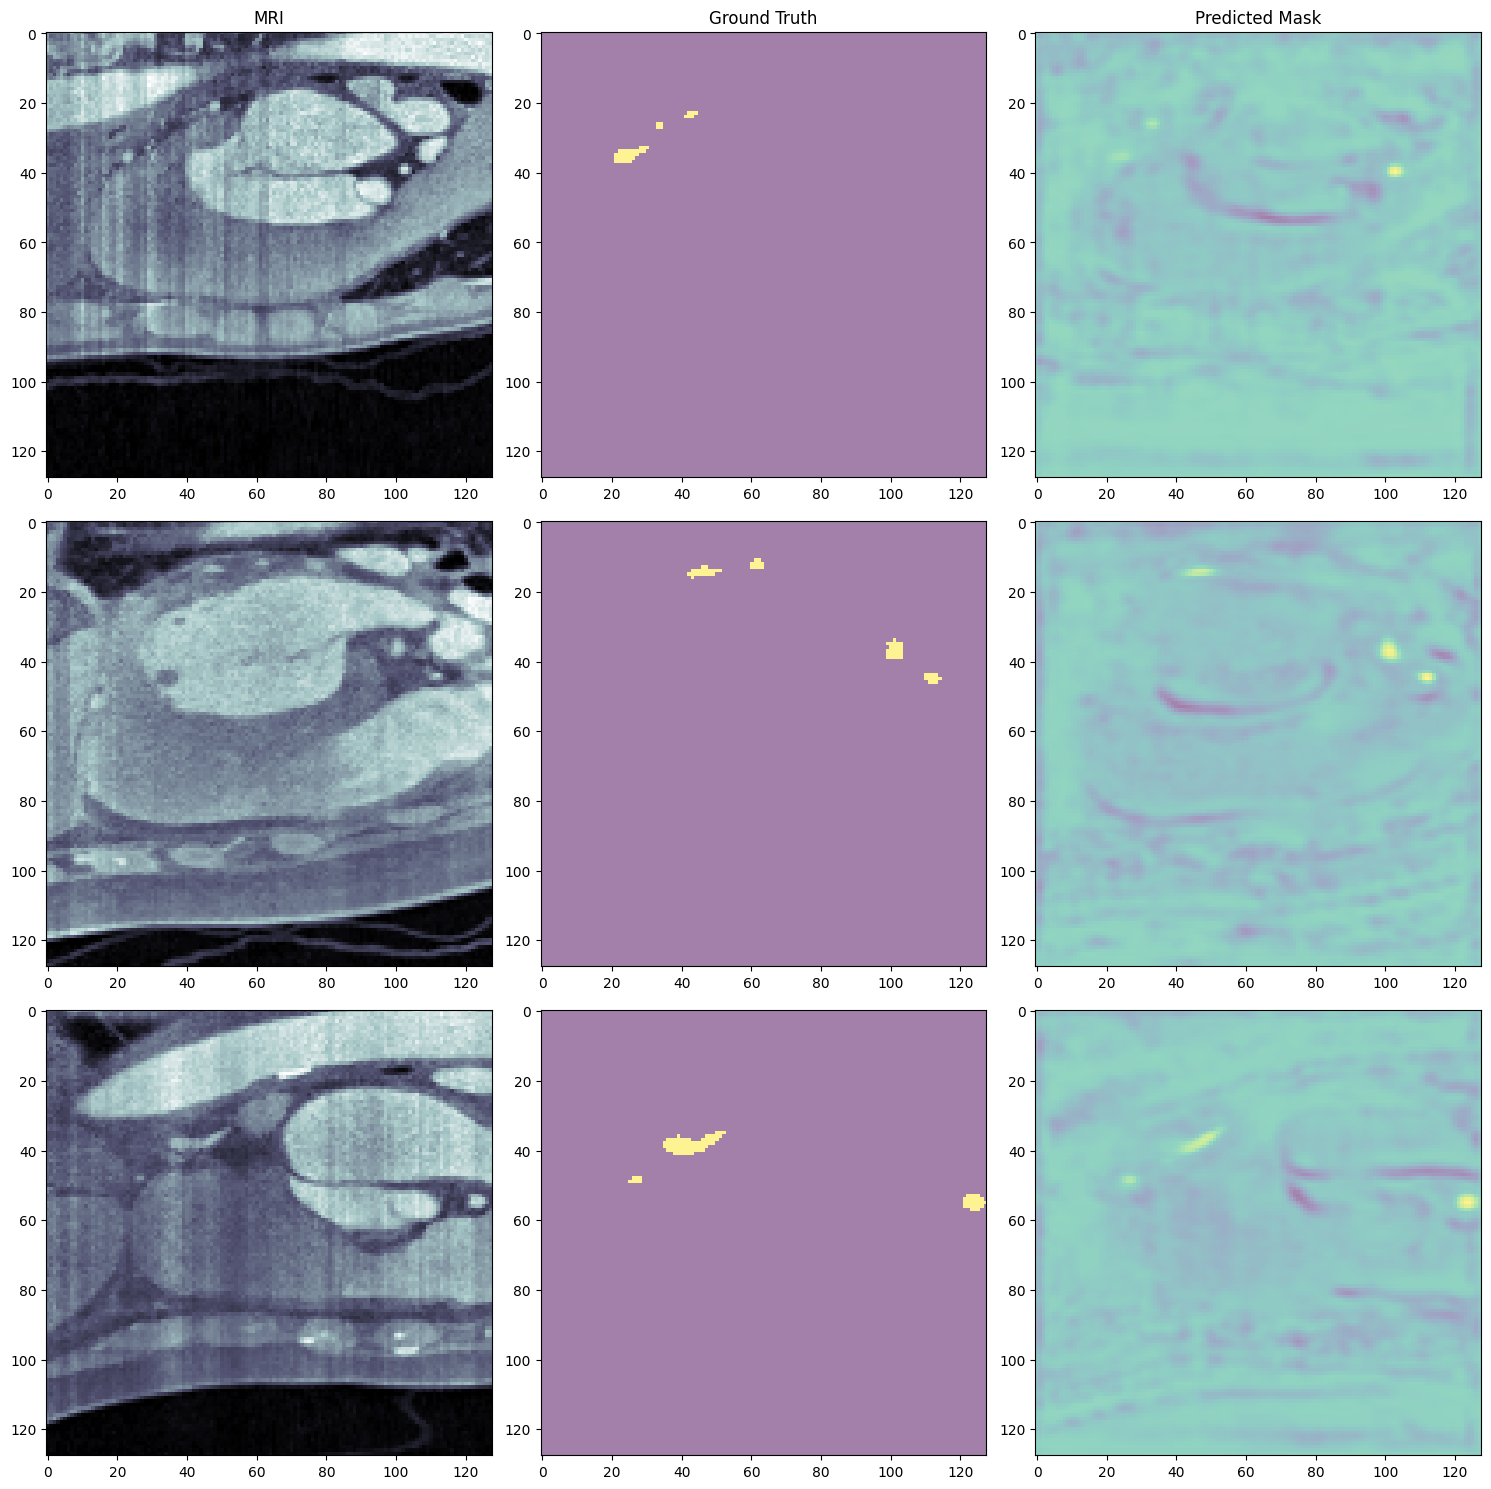

In [37]:
visualize_segmentation(UnetModel, test_loader, 3, device)

In [38]:
import matplotlib.pyplot as plt
import torch
import gc

def visualize_segmentation_with_overlay(model, data_loader, num_samples=5, device='cuda'):
    # Visualize segmentation on unseen samples with overlay
    fig, axs = plt.subplots(num_samples, 3, figsize=(15, 5 * num_samples))

    # Check if there is only one sample
    if num_samples == 1:
        axs = [axs]  # Convert to a list to handle single sample case uniformly

    for ax, col in zip(axs[0], ['CT_scan', 'MRI & Ground Truth', 'MRI & Predicted segment']):
        ax.set_title(col)

    index = 0
    for batch in data_loader:
        img = batch[0].to(device)
        msk = batch[1].to(device)
        model.eval()
        output = model(img)
        
        torch.cuda.empty_cache()
        gc.collect()

        for j in range(batch[0].size()[0]):  # iterate over batch size
            img_cpu = img[j].detach().cpu().numpy()  # Convert to numpy array after moving to CPU
            msk_cpu = torch.squeeze(msk[j]).detach().cpu().numpy()
            output_cpu = torch.squeeze(output[j]).detach().cpu().numpy()

            # Select a 2D slice from the 3D volume
            slice_index = img_cpu.shape[1] // 2  # Select the middle slice along the z-axis

            axs[index][0].imshow(img_cpu[0, slice_index], cmap='bone', interpolation='none')

            # Plot grond truth overlayed on Mri Image image
            axs[index][1].imshow(img_cpu[0, slice_index], cmap='bone', interpolation='none')

            # Plot the ground truth mask
            axs[index][1].imshow(msk_cpu[slice_index], cmap='bone', interpolation='none', alpha=0.5)

            # Plot the predicted mask overlaid on the MRI image
            overlay = output_cpu[slice_index]
            axs[index][2].imshow(img_cpu[0, slice_index], cmap='bone', interpolation='none')
            axs[index][2].imshow(overlay, cmap='bone', interpolation='none', alpha=0.5)

            index += 1
            if index >= num_samples:
                break

        if index >= num_samples:
            break

    plt.tight_layout()
    plt.show()


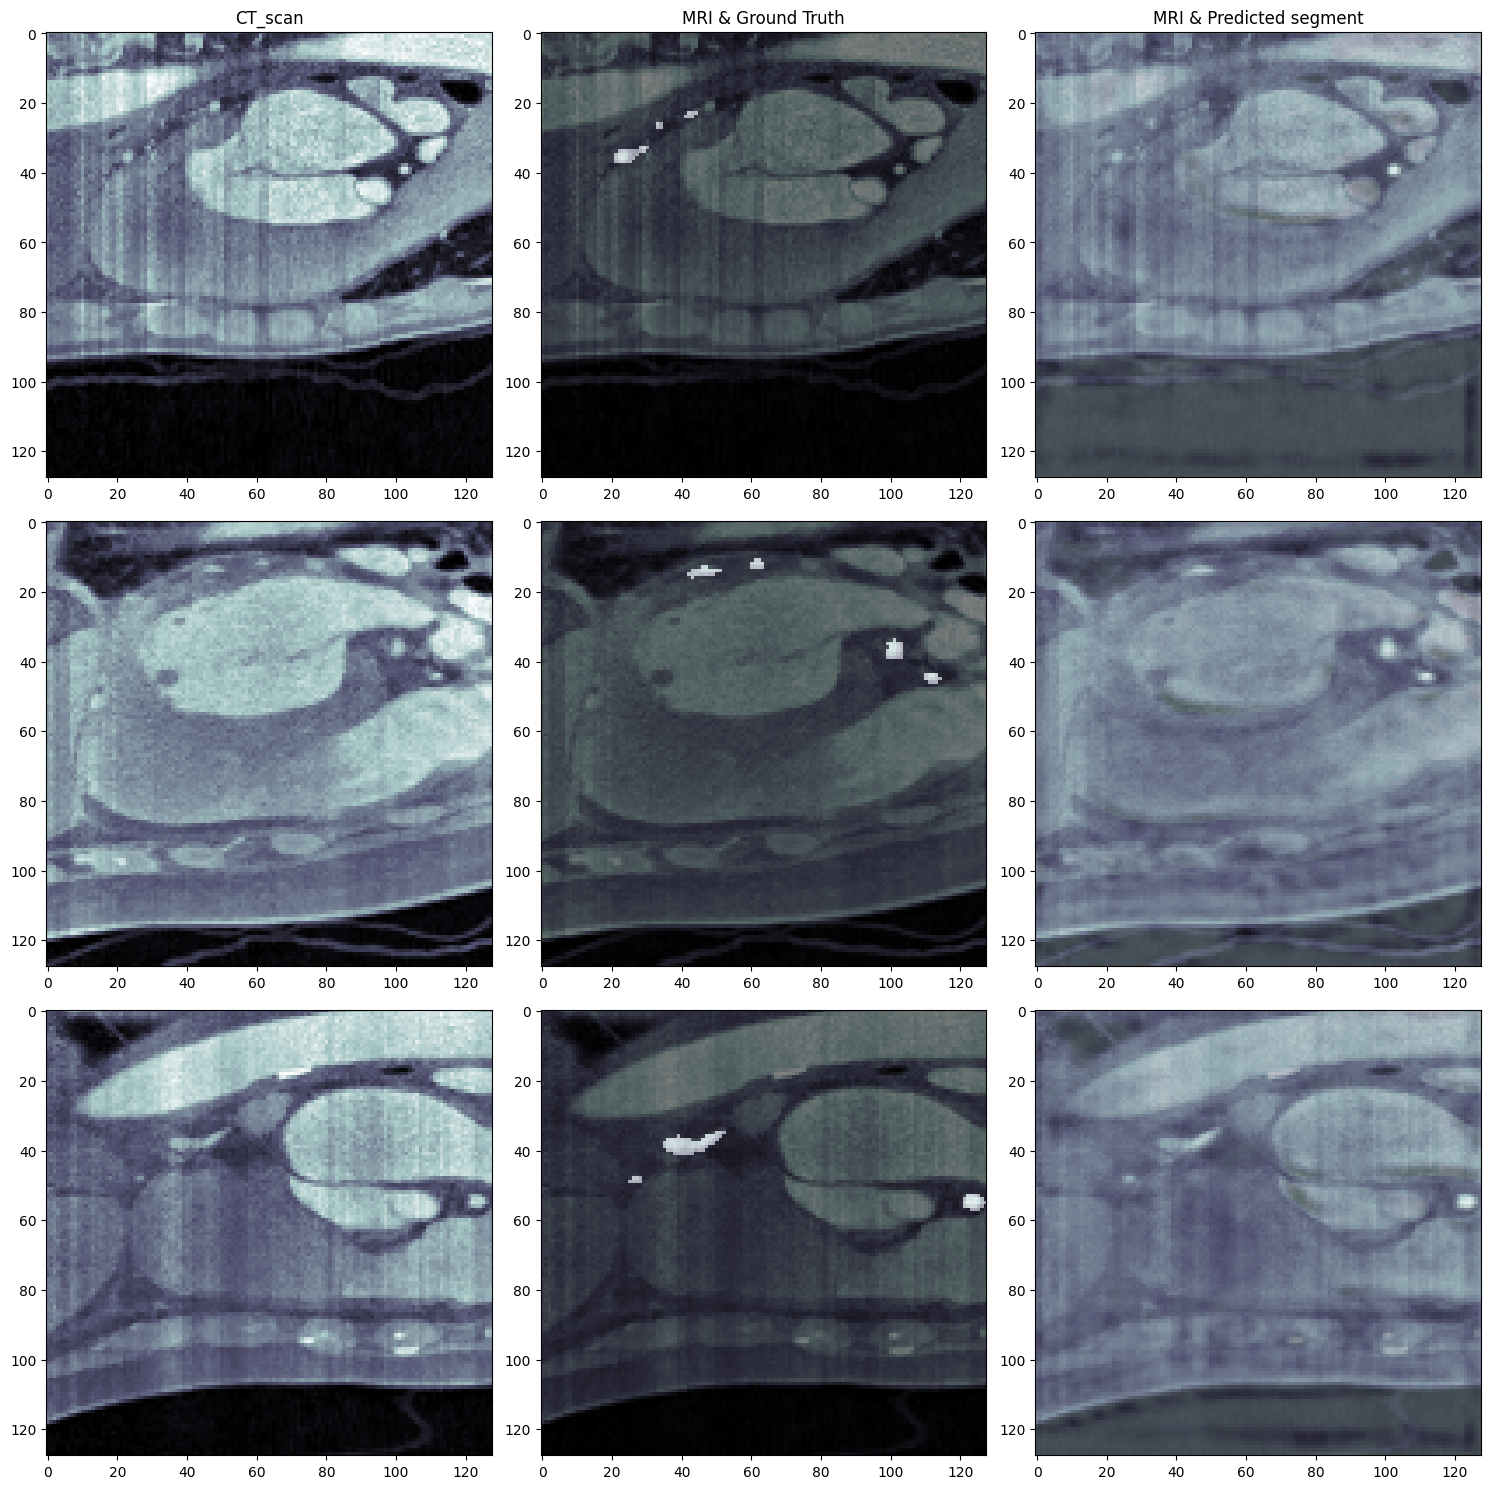

In [39]:
visualize_segmentation_with_overlay(UnetModel, test_loader, 3, device)

In [40]:
import matplotlib.pyplot as plt
import torch
import gc

def multiple_visualize_segmentation_with_overlay(model, data_loader, num_samples=5, device='cuda'):
    # Define the number of slices to display per patient
    slices_per_patient = 6

    # Calculate total subplots needed
    total_slices = slices_per_patient * num_samples
    fig, axs = plt.subplots(total_slices, 3, figsize=(15, 5 * total_slices))

    # Flatten axs if num_samples is 1
    if total_slices == 1:
        axs = [axs]  # Convert to a list to handle single sample case uniformly
    else:
        axs = axs.reshape(total_slices, 3)

    for ax, col in zip(axs[0], ['CT_scan', 'CT_scan & Ground Truth', 'CT_scan & Prediction']):
        ax.set_title(col)

    index = 0
    for batch_index, batch in enumerate(data_loader):
        img = batch[0].to(device)
        msk = batch[1].to(device)
        model.eval()
        output = model(img)
        
        torch.cuda.empty_cache()
        gc.collect()

        for j in range(batch[0].size()[0]):  # iterate over batch size
            img_cpu = img[j].detach().cpu().numpy()  # Convert to numpy array after moving to CPU
            msk_cpu = torch.squeeze(msk[j]).detach().cpu().numpy()
            output_cpu = torch.squeeze(output[j]).detach().cpu().numpy()

            # Select a 2D slice from the 3D volume
            slice_indices = [0, 15, 30, 45, 60, 75]  # Select the slice indices

            for slice_index in slice_indices:
                if index >= total_slices:
                    break

                # Plot MRI image
                axs[index, 0].imshow(img_cpu[0, slice_index], cmap='bone', interpolation='none')
                axs[index, 0].set_title(f'Patient {batch_index} Slice {slice_index} CT_scan')

                # Plot ground truth overlayed on MRI image
                axs[index, 1].imshow(img_cpu[0, slice_index], cmap='bone', interpolation='none')
                axs[index, 1].imshow(msk_cpu[slice_index], cmap='bone', interpolation='none', alpha=0.5)
                axs[index, 1].set_title('CT_scan & Ground Truth')

                # Plot predicted mask overlaid on MRI image
                overlay = output_cpu[slice_index]
                axs[index, 2].imshow(img_cpu[0, slice_index], cmap='bone', interpolation='none')
                axs[index, 2].imshow(overlay, cmap='bone', interpolation='none', alpha=0.5)
                axs[index, 2].set_title('CT_scan & Prediction')

                index += 1

            if index >= total_slices:
                break

        if index >= total_slices:
            break

    plt.tight_layout()
    plt.show()

# Example usage:
# multiple_visual


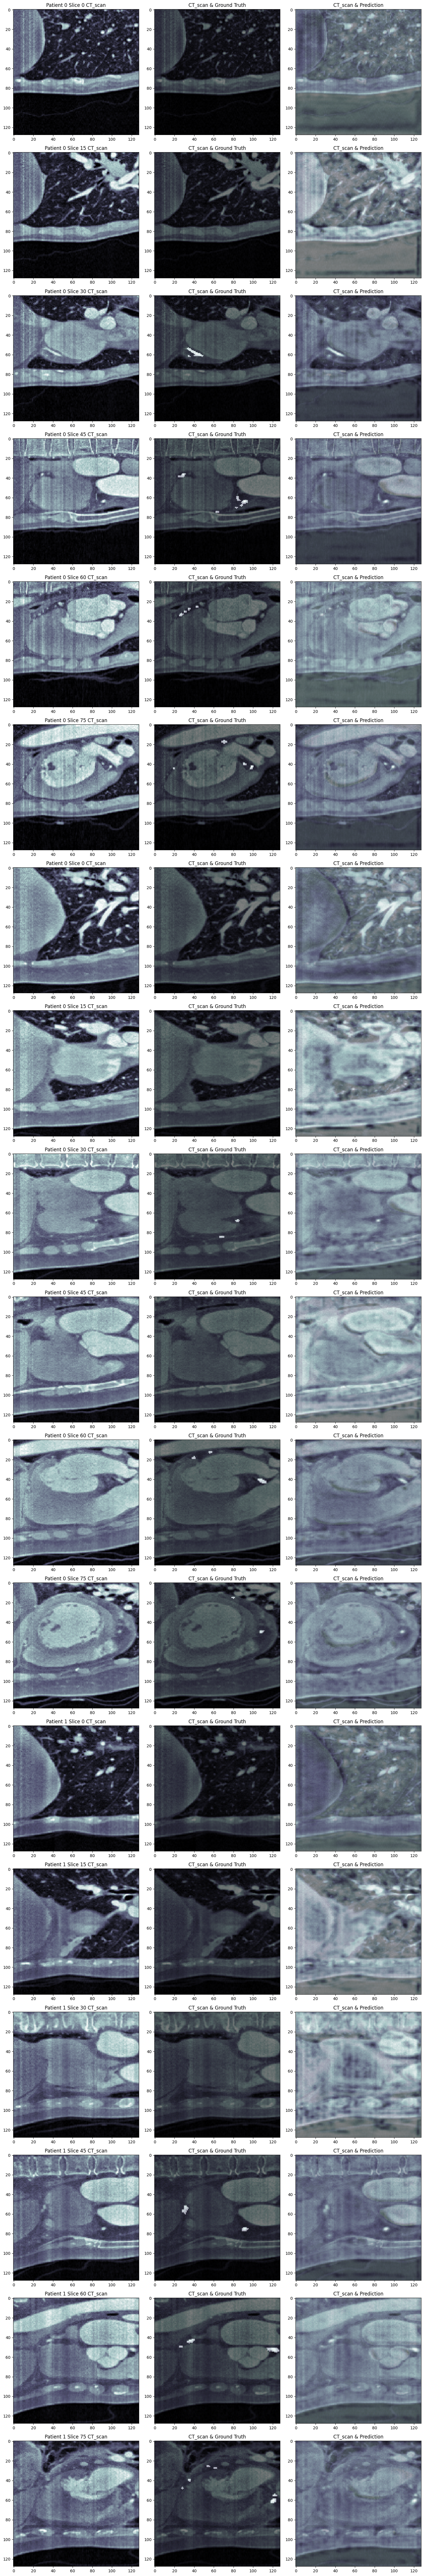

In [41]:
multiple_visualize_segmentation_with_overlay(UnetModel, test_loader, 3, device)

## 3D visualization

In [42]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # Importing 3D plotting tools from Matplotlib
import torch
import gc

def visualize_segmentation_3d(model, data_loader, num_samples=1, device='cuda'):
    fig = plt.figure(figsize=(15, 5 * num_samples))
    ax = fig.add_subplot(111, projection='3d')  # Create a 3D subplot

    index = 0
    for batch in data_loader:
        img = batch[0].to(device)
        msk = batch[1].to(device)
        model.eval()
        output = model(img)
        
        torch.cuda.empty_cache()
        gc.collect()

        for j in range(batch[0].size()[0]):  # iterate over batch size
            img_cpu = img[j].detach().cpu().numpy()  # Convert to numpy array after moving to CPU
            msk_cpu = torch.squeeze(msk[j]).detach().cpu().numpy()
            output_cpu = torch.squeeze(output[j]).detach().cpu().numpy()

            # Stack masks and predictions for 3D visualization
            stacked_mask = np.stack([msk_cpu] * 3, axis=-1)  # Assuming 3 channels for visualization
            stacked_output = np.stack([output_cpu] * 3, axis=-1)  # Assuming 3 channels for visualization

            # Create a meshgrid for 3D visualization
            c, D, H, W = img_cpu.shape
            x, y, z = np.meshgrid(np.arange(W), np.arange(H), np.arange(D))

            # Plot the ground truth mask in 3D
            ax.scatter(x[msk_cpu > 0.1], y[msk_cpu > 0.1], z[msk_cpu > 0.1], c='g', marker='o', alpha=0.5, label='Ground Truth Mask')

            # Plot the predicted mask in 3D
            ax.scatter(x[output_cpu > 0.1], y[output_cpu > 0.1], z[output_cpu > 0.1], c='b', marker='^', alpha=0.5, label='Predicted Mask')

            ax.set_xlabel('X')
            ax.set_ylabel('Y')
            ax.set_zlabel('Z')
            ax.legend()

            index += 1
            if index >= num_samples:
                break

        if index >= num_samples:
            break

    plt.tight_layout()
    plt.show()

# Example usage:
# visualize_segmentation_3d(UnetModel, test_loader, 2, device)


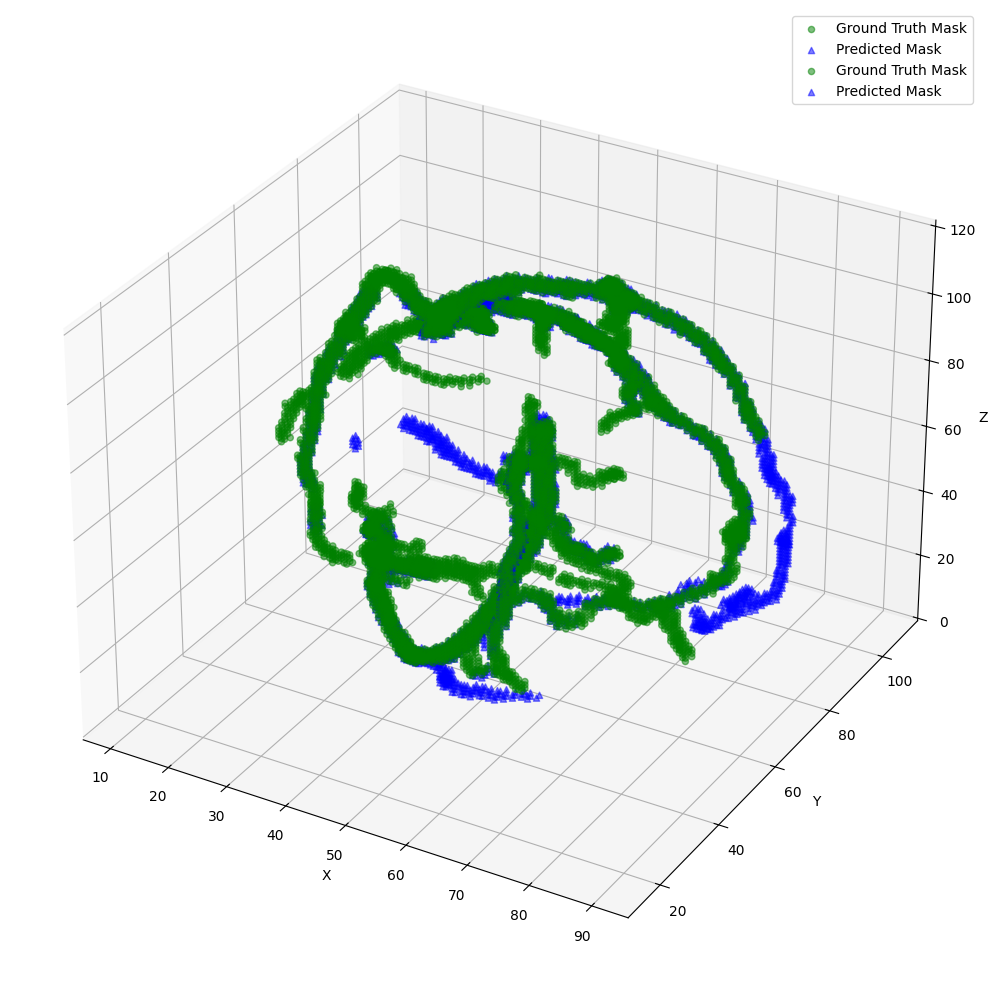

In [43]:
visualize_segmentation_3d(UnetModel, test_loader, 2, device)